In [133]:
from torch import nn
import torch.nn.functional as F
from skimage.feature import hessian_matrix
import torch
class Conv_module(nn.Module):

  def __init__(self):
    super(Conv_module,self).__init__()
    # Gaussian 
    self.gauss = torch.tensor([[0.04779009, 0.04779009, 0.04779009],
       [0.90441981, 0.90441981, 0.90441981],
       [0.04779009, 0.04779009, 0.04779009]]).view(1, 1, 3, 3).repeat(1, 1, 1, 1)

    # Sobel x
    self.sobel_x = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]])
    
    self.w_sobel_x = self.sobel_x.view(1, 1, 3, 3).repeat(1, 1, 1, 1) # Add .expand(4, 1, channels, 3, 3)

    # Sobel y
    self.sobel_y = self.sobel_x.t()
    self.w_sobel_y = self.sobel_y.view(1, 1, 3, 3).repeat(1, 1, 1, 1) # Add .expand(4, 1, channels, 3, 3)

    # finite diff grad_x
    self.grad_x = torch.tensor([[-1., 0., 1.],
                        [-1.,0., 1.],
                        [-1., 0., 1.]])
    self.w_grad_x = self.grad_x.view(1, 1, 3, 3).repeat(1, 1, 1, 1)

    # finite diff grad_y
    self.grad_y = self.grad_x.t()
    self.w_grad_y = self.grad_y.view(1, 1, 3, 3).repeat(1, 1, 1, 1)
    

  def forward(self, x):
    '''
    H_xx = F.conv2d(F.conv2d(x,self.w_sobel_x),self.w_grad_x)
    H_yy = F.conv2d(F.conv2d(x,self.w_sobel_y),self.w_grad_y)
    H_xy = F.conv2d(F.conv2d(x,self.w_sobel_y),self.w_grad_x)
    '''
    H_xx = F.conv2d(F.conv2d(F.conv2d(x,self.gauss),self.w_grad_x),self.w_grad_x)
    H_yy = F.conv2d(F.conv2d(F.conv2d(x,self.gauss),self.w_grad_y),self.w_grad_y)
    H_xy = F.conv2d(F.conv2d(F.conv2d(x,self.gauss),self.w_grad_x),self.w_grad_y)

    lambda_2 = ((H_xx + H_yy) + torch.sqrt((H_xx-H_yy)**2+ 4*H_xy**2))/2

    lambda_1 = ((H_xx + H_yy) - torch.sqrt((H_xx-H_yy)**2+ 4*H_xy**2))/2 

    lambda_2_normed = 2*(lambda_2 -torch.min(lambda_2))/(torch.max(lambda_2)-torch.min(lambda_2))-1

    mask_lambda_2 = (lambda_2_normed>0) + 0.

    # Add 1e-4 for stability
    R_b = torch.mul((lambda_1/(lambda_2+1e-4)),(lambda_1/(lambda_2+1e-4)))

    S = torch.sqrt(lambda_1**2 + lambda_2**2)

    beta = 0.5
    c = 15

    V_0 = torch.exp(-R_b**2/(2*(beta**2)))*(1-torch.exp(-S**2/(2*(c**2))))

    V_1 = V_0*mask_lambda_2

    return  F.conv2d(x,self.gauss), F.conv2d(F.conv2d(x,self.gauss),self.w_grad_x),lambda_1, lambda_2, mask_lambda_2, V_0, V_1


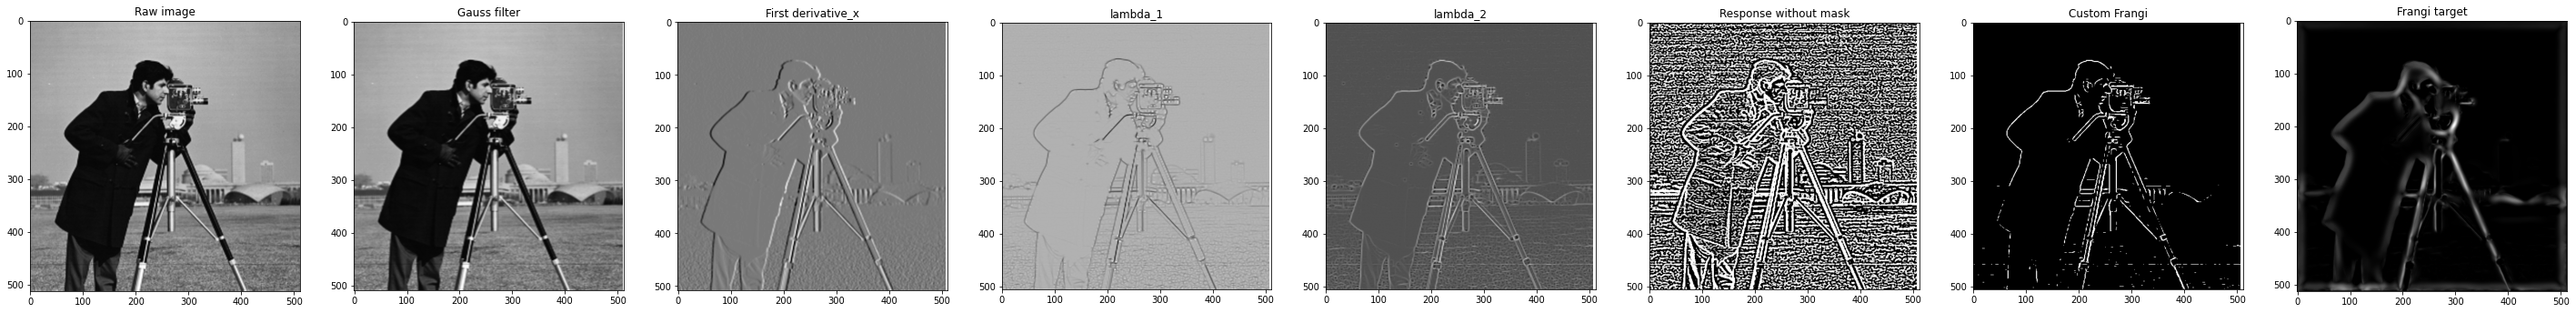

In [134]:
from skimage.data import camera
from skimage.filters import frangi, hessian
import numpy as np
import matplotlib.pyplot as plt

image = camera()

input = torch.empty(1, 1,224,224).normal_()
model = Conv_module()
#vo = model.forward(input)

img = torch.tensor(image).view(1, 1, 512, 512)
gauss, gauss_dx, lambda_1, lambda_2, mask, V0, V1 = model.forward(img.float())

gauss = gauss.view(gauss.size()[2],gauss.size()[3]).numpy()
gauss_dx = gauss_dx.view(gauss_dx.size()[2],gauss_dx.size()[3]).numpy()

lambda_1 = lambda_1.view(lambda_1.size()[2],lambda_1.size()[3]).numpy()
lambda_2 = lambda_2.view(lambda_2.size()[2],lambda_2.size()[3]).numpy()
mask = mask.view(mask.size()[2],mask.size()[3]).numpy()
V0 = V0.view(V0.size()[2],V0.size()[3]).numpy()
V1 = V1.view(V1.size()[2],V1.size()[3]).numpy()

import matplotlib.pyplot as plt
#imgg = (img*255).astype('uint8')
fig, axs = plt.subplots(ncols=8, sharex=True, figsize=(50, 50))
axs[0].set_title('Raw image')
axs[0].imshow(image, origin='upper', cmap='gray')
axs[1].set_title('Gauss filter')
axs[1].imshow(gauss, origin='upper', cmap='gray')
axs[2].set_title('First derivative_x')
axs[2].imshow(gauss_dx, origin='upper', cmap='gray')
axs[3].set_title('lambda_1')
axs[3].imshow(lambda_1, origin='upper', cmap='gray')
axs[4].set_title('lambda_2')
axs[4].imshow(lambda_2, origin='upper', cmap='gray')
axs[5].set_title('Response without mask')
axs[5].imshow(V0, origin='upper', cmap='gray')
axs[6].set_title('Custom Frangi')
axs[6].imshow(V1, origin='upper', cmap='gray')
axs[7].imshow(frangi(image), cmap=plt.cm.gray)
axs[7].set_title('Frangi target')
plt.show()

In [135]:
import numpy as np
import scipy.stats as st

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel. Taken from https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy"""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()
K = gkern(3, 5)
print('Gaussian kernel', K/sum(K))

Gaussian kernel [[0.04779009 0.04779009 0.04779009]
 [0.90441981 0.90441981 0.90441981]
 [0.04779009 0.04779009 0.04779009]]
